# Tittle: Deap Learning Aproach for Customer Churn Prediction 

# Introduction

This project aims to construct a churn prediction model that has the highest accuracy without overfitting. In particular, I compared seven different supervised learning models (Logistic Regression, KNeighborsClassifier, Decision TreeClassifier, GaussianNB, RandomForestClassifier and XGBoost) as well as a combined voting ensemble for all selected models to choose the best model that has the highest accuracy to identify customers who are likely to stop using service in the future.

For features selection, I considered a correlation-based approach to select a list of a feature that trade-off average correlation with the dependent variable and other selected features. For example,  if two variables are perfectly correlated, I  used economic theory to drop the irrelevant variable and choose the most relevant variable for the final model. 

This approach is well suited for churn prediction because (1) can visualise the relationship that exists between each of the explanatory variable and dependent variable. (2) can easily remove irrelevant variables where the sophisticated model would give preference to redundant variables. 

#    # Aims


 I: Identify the Churn customers. II: Identification of different features that influence churn. 
 III:Application correlation graph for features selection. IV: Comparison of 7 different supervised leaning model and created combined voting ensemble for all selected models. 



# Contents

In [ ]:

[1: Import of appropriate libraries 
[2: Data extraction for Microsoft Sql server
[3: Identification of the churn customers
[4: Data preparation & visualization
[5: Feature selection
[6: Dataset validation
[7:Improve performance of the selected models with the Boosting
[8.Improve performance of the selected model with combined Voting Classifier using soft voting
[9: Model Evaluation 



# 1. Loading the libraries

In [166]:

%matplotlib inline
import datetime as dt
import pyodbc 
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,BaggingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error
import csv
import warnings
warnings.filterwarnings('ignore')

# 2: Data extraction for Microsoft Sql server

In [167]:
#Create a connection from Python to SQL
cnxn = pyodbc.connect("Driver={SQL Server Native Client 11.0};"
                      "Server=HP;"
                      "Database=AdventureWorksDW2014;"
                      "Trusted_Connection=yes;")

In [168]:
#Import Factinternetsales
fctintsales = pd.read_sql_query("""
SELECT
[CustomerKey]
,[OrderQuantity]
,[SalesAmount]
,[OrderDate]
,[SalesTerritoryKey]
FROM [dbo].[FactInternetSales]""", cnxn)

In [169]:
fctintsales.head(5)

,CustomerKey,OrderQuantity,SalesAmount,OrderDate,SalesTerritoryKey
0,21768,1,3578.2700,2010-12-29,6
1,28389,1,3399.9900,2010-12-29,7
2,25863,1,3399.9900,2010-12-29,1
3,14501,1,699.0982,2010-12-29,4
4,11003,1,3399.9900,2010-12-29,9


In [170]:
#Import Customer Table
custtbl = pd.read_sql_query("""
SELECT
[CustomerKey]
,[BirthDate]
,[MaritalStatus]
,[Gender]
,[YearlyIncome]
,[TotalChildren]
,[NumberChildrenAtHome]
,[EnglishEducation]
,[EnglishOccupation]
,[HouseOwnerFlag]
,[NumberCarsOwned]
,[DateFirstPurchase]
,[CommuteDistance]
FROM [dbo].[DimCustomer]""", cnxn)

In [171]:
#Import Factinternetsalesreason
fctinsalesreason = pd.read_sql_query("""
SELECT *
FROM [dbo].[FactInternetSalesReason]""", cnxn)

In [172]:
#Import salesreason
salesreason = pd.read_sql_query("""
SELECT *
FROM [dbo].[DimSalesReason]""", cnxn)

In [173]:
new_fctintsales = fctintsales.groupby('CustomerKey').agg({'SalesAmount':['sum', 'max', 'min','mean','median'], 
                         'OrderQuantity':['sum', 'max', 'min','mean','median'], 
                         'OrderDate':'max'})

In [174]:
new_fctintsales.head(5)

SalesAmount                                       OrderQuantity  \
                    sum      max    min         mean   median           sum   
CustomerKey                                                                   
11000           8248.99  3399.99   4.99  1031.123750    44.49             8   
11001           6383.88  3374.99   4.99   580.352727    21.98            11   
11002           8114.04  3399.99  34.99  2028.510000  2339.53             4   
11003           8139.29  3399.99   2.29   904.365556     9.99             9   
11004           8196.01  3399.99  21.98  1366.001667  1177.49             6   

                                 OrderDate  
            max min mean median        max  
CustomerKey                                 
11000         1   1    1      1 2013-05-03  
11001         1   1    1      1 2013-12-10  
11002         1   1    1      1 2013-02-23  
11003         1   1    1      1 2013-05-10  
11004         1   1    1      1 2013-05-01

In [175]:
#Join the field names to the newly aggregate fields names
new_fctintsales.columns = ["_".join(new_fctintsales) for new_fctintsales in new_fctintsales.columns.ravel()]

In [176]:
#Reset the index
new_fctintsales = new_fctintsales.reset_index()

In [177]:
new_fctintsales.head(2)

,CustomerKey,SalesAmount_sum,SalesAmount_max,SalesAmount_min,SalesAmount_mean,SalesAmount_median,OrderQuantity_sum,OrderQuantity_max,OrderQuantity_min,OrderQuantity_mean,OrderQuantity_median,OrderDate_max
0,11000,8248.99,3399.99,4.99,1031.123750,44.49,8,1,1,1,1,2013-05-03
1,11001,6383.88,3374.99,4.99,580.352727,21.98,11,1,1,1,1,2013-12-10


In [178]:
#Merging the aggregated field with customer table
result = pd.merge(new_fctintsales,
                 custtbl,
                 on='CustomerKey')
result.head()

,CustomerKey,SalesAmount_sum,SalesAmount_max,SalesAmount_min,SalesAmount_mean,SalesAmount_median,OrderQuantity_sum,OrderQuantity_max,OrderQuantity_min,OrderQuantity_mean,...,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,EnglishEducation,EnglishOccupation,HouseOwnerFlag,NumberCarsOwned,DateFirstPurchase,CommuteDistance
0,11000,8248.99,3399.99,4.99,1031.123750,44.49,8,1,1,1,...,M,90000.0,2,0,Bachelors,Professional,1,0,2011-01-19,1-2 Miles
1,11001,6383.88,3374.99,4.99,580.352727,21.98,11,1,1,1,...,M,60000.0,3,3,Bachelors,Professional,0,1,2011-01-15,0-1 Miles
2,11002,8114.04,3399.99,34.99,2028.510000,2339.53,4,1,1,1,...,M,60000.0,3,3,Bachelors,Professional,1,1,2011-01-07,2-5 Miles
3,11003,8139.29,3399.99,2.29,904.365556,9.99,9,1,1,1,...,F,70000.0,0,0,Bachelors,Professional,0,1,2010-12-29,5-10 Miles
4,11004,8196.01,3399.99,21.98,1366.001667,1177.49,6,1,1,1,...,F,80000.0,5,5,Bachelors,Professional,1,4,2011-01-23,1-2 Miles


In [179]:
#Prepare Salesreason data
reason = pd.merge(fctinsalesreason,
                 salesreason,
                 on='SalesReasonKey')
reason.head()

,SalesOrderNumber,SalesOrderLineNumber,SalesReasonKey,SalesReasonAlternateKey,SalesReasonName,SalesReasonReasonType
0,SO43697,1,5,5,Manufacturer,Other
1,SO43702,1,5,5,Manufacturer,Other
2,SO43703,1,5,5,Manufacturer,Other
3,SO43706,1,5,5,Manufacturer,Other
4,SO43707,1,5,5,Manufacturer,Other


In [180]:
#Dummify the Salesreasonname so that the values becomes variables
reason_ = pd.get_dummies(reason.SalesReasonName,columns=['Price', 'On Promotion', 'Magazine Advertisement','TV', 'Manufacturer', 'Review','Demo Event', 'Sponsorship', 'Quality', 'Other'])

In [181]:
reason = pd.concat([reason, reason_], axis=1)

In [182]:
reason.tail(20)

,SalesOrderNumber,SalesOrderLineNumber,SalesReasonKey,SalesReasonAlternateKey,SalesReasonName,SalesReasonReasonType,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement
64495,SO74782,1,4,4,Television Advertisement,Marketing,0,0,0,0,0,0,1
64496,SO74792,1,4,4,Television Advertisement,Marketing,0,0,0,0,0,0,1
64497,SO74798,1,4,4,Television Advertisement,Marketing,0,0,0,0,0,0,1
64498,SO74799,1,4,4,Television Advertisement,Marketing,0,0,0,0,0,0,1
64499,SO74814,1,4,4,Television Advertisement,Marketing,0,0,0,0,0,0,1
64500,SO74873,1,4,4,Television Advertisement,Marketing,0,0,0,0,0,0,1
64501,SO74878,1,4,4,Television Advertisement,Marketing,0,0,0,0,0,0,1
64502,SO74917,1,4,4,Television Advertisement,Marketing,0,0,0,0,0,0,1
64503,SO74919,1,4,4,Television Advertisement,Marketing,0,0,0,0,0,0,1
64504,SO74924,1,4,4,Television Advertisement,Marketing,0,0,0,0,0,0,1


In [183]:
reason.head(5)

,SalesOrderNumber,SalesOrderLineNumber,SalesReasonKey,SalesReasonAlternateKey,SalesReasonName,SalesReasonReasonType,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement
0,SO43697,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0
1,SO43702,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0
2,SO43703,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0
3,SO43706,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0
4,SO43707,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0


In [184]:
#Re Import Factinternetsales
fctintsales = pd.read_sql_query("""
SELECT
[CustomerKey]
,[SalesOrderNumber]
FROM [dbo].[FactInternetSales]""", cnxn)

In [185]:
#Join factinternetsales back to prepared Salesreason data
reason = pd.merge(fctintsales,
                 reason,
                 on='SalesOrderNumber')

In [186]:
reason = reason.groupby('CustomerKey').agg({'Manufacturer':'max', 
                         'On Promotion':'max', 
                         'Other':'max',
                          'Price':'max',
                            'Quality':'max',
                              'Review':'max',
                                'Television  Advertisement':'max'}).reset_index()

In [187]:
reason.head(5)

,CustomerKey,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement
0,11000,0,1,0,1,0,0,0
1,11001,0,0,0,1,0,0,0
2,11002,0,1,0,0,0,0,0
3,11003,0,0,0,1,0,0,0
4,11004,0,0,0,1,0,0,0


In [188]:
#left join main data back to result
final_data = pd.merge(result,
                 reason,
                 on='CustomerKey', how='left')


In [189]:
final_data.head(5)

,CustomerKey,SalesAmount_sum,SalesAmount_max,SalesAmount_min,SalesAmount_mean,SalesAmount_median,OrderQuantity_sum,OrderQuantity_max,OrderQuantity_min,OrderQuantity_mean,...,NumberCarsOwned,DateFirstPurchase,CommuteDistance,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement
0,11000,8248.99,3399.99,4.99,1031.123750,44.49,8,1,1,1,...,0,2011-01-19,1-2 Miles,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,11001,6383.88,3374.99,4.99,580.352727,21.98,11,1,1,1,...,1,2011-01-15,0-1 Miles,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,11002,8114.04,3399.99,34.99,2028.510000,2339.53,4,1,1,1,...,1,2011-01-07,2-5 Miles,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,11003,8139.29,3399.99,2.29,904.365556,9.99,9,1,1,1,...,1,2010-12-29,5-10 Miles,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,11004,8196.01,3399.99,21.98,1366.001667,1177.49,6,1,1,1,...,4,2011-01-23,1-2 Miles,0.0,0.0,0.0,1.0,0.0,0.0,0.0


# 3. Identification of the churn customers

In [190]:
#derive age, tenure and churn field
#df['nb_months'] = ((df.date2 - df.date1)/np.timedelta64(1, 'M'))
# we categorised customers that have not made any transaction for the last 12 months as a churn. 

final_data['Tenure_Months'] = ((final_data['OrderDate_max'].dt.date -  final_data['DateFirstPurchase'])/np.timedelta64(1, 'M')).astype(int)
final_data['Age_years'] = ((final_data['OrderDate_max'].dt.date -  final_data['BirthDate'])/np.timedelta64(1, 'Y')).astype(int)
final_data['Last_purchase_date'] = final_data['OrderDate_max'].dt.date
final_data['Cuttoff_date'] = '2013-05-03'

# 4. Data preparation and visualization 

In [191]:
final_data.head(5)
final_data.dtypes

CustomerKey                           int64
SalesAmount_sum                     float64
SalesAmount_max                     float64
SalesAmount_min                     float64
SalesAmount_mean                    float64
SalesAmount_median                  float64
OrderQuantity_sum                     int64
OrderQuantity_max                     int64
OrderQuantity_min                     int64
OrderQuantity_mean                    int64
OrderQuantity_median                  int64
OrderDate_max                datetime64[ns]
BirthDate                            object
MaritalStatus                        object
Gender                               object
YearlyIncome                        float64
TotalChildren                         int64
NumberChildrenAtHome                  int64
EnglishEducation                     object
EnglishOccupation                    object
HouseOwnerFlag                       object
NumberCarsOwned                       int64
DateFirstPurchase               

In [192]:
#Convert dates from objects to date formats
final_data['Last_purchase_date'] = pd.to_datetime(final_data['Last_purchase_date'],format="%Y-%m-%d")
final_data['Cuttoff_date'] = pd.to_datetime(final_data['Cuttoff_date'],format="%Y-%m-%d")

In [193]:
#final_data['Churn'] = np.where(final_data['Last_purchase_date'] = '2013-05-03', 0, 1)
#final_data['Churn'] = final_data['Last_purchase_date'].apply(lambda x: 1 if (x >= final_data['Cuttoff_date'] else "0"))
#final_data.dtypes
#Create Churn field (Target variable)
final_data['Churn'] = np.where(final_data['Last_purchase_date'] <= final_data['Cuttoff_date'] , 1, 0)

In [194]:
final_data.head(5)

,CustomerKey,SalesAmount_sum,SalesAmount_max,SalesAmount_min,SalesAmount_mean,SalesAmount_median,OrderQuantity_sum,OrderQuantity_max,OrderQuantity_min,OrderQuantity_mean,...,Other,Price,Quality,Review,Television Advertisement,Tenure_Months,Age_years,Last_purchase_date,Cuttoff_date,Churn
0,11000,8248.99,3399.99,4.99,1031.123750,44.49,8,1,1,1,...,0.0,1.0,0.0,0.0,0.0,27,41,2013-05-03,2013-05-03,1
1,11001,6383.88,3374.99,4.99,580.352727,21.98,11,1,1,1,...,0.0,1.0,0.0,0.0,0.0,34,37,2013-12-10,2013-05-03,0
2,11002,8114.04,3399.99,34.99,2028.510000,2339.53,4,1,1,1,...,0.0,0.0,0.0,0.0,0.0,25,42,2013-02-23,2013-05-03,1
3,11003,8139.29,3399.99,2.29,904.365556,9.99,9,1,1,1,...,0.0,1.0,0.0,0.0,0.0,28,39,2013-05-10,2013-05-03,0
4,11004,8196.01,3399.99,21.98,1366.001667,1177.49,6,1,1,1,...,0.0,1.0,0.0,0.0,0.0,27,33,2013-05-01,2013-05-03,1


In [195]:
#dummfy all categorical variables
#final_data.dtypes
final_data = pd.get_dummies(final_data, columns=['MaritalStatus','Gender','EnglishEducation','EnglishOccupation','HouseOwnerFlag','CommuteDistance'], drop_first = False)

In [196]:
final_data.head(5)

,CustomerKey,SalesAmount_sum,SalesAmount_max,SalesAmount_min,SalesAmount_mean,SalesAmount_median,OrderQuantity_sum,OrderQuantity_max,OrderQuantity_min,OrderQuantity_mean,...,EnglishOccupation_Manual,EnglishOccupation_Professional,EnglishOccupation_Skilled Manual,HouseOwnerFlag_0,HouseOwnerFlag_1,CommuteDistance_0-1 Miles,CommuteDistance_1-2 Miles,CommuteDistance_10+ Miles,CommuteDistance_2-5 Miles,CommuteDistance_5-10 Miles
0,11000,8248.99,3399.99,4.99,1031.123750,44.49,8,1,1,1,...,0,1,0,0,1,0,1,0,0,0
1,11001,6383.88,3374.99,4.99,580.352727,21.98,11,1,1,1,...,0,1,0,1,0,1,0,0,0,0
2,11002,8114.04,3399.99,34.99,2028.510000,2339.53,4,1,1,1,...,0,1,0,0,1,0,0,0,1,0
3,11003,8139.29,3399.99,2.29,904.365556,9.99,9,1,1,1,...,0,1,0,1,0,0,0,0,0,1
4,11004,8196.01,3399.99,21.98,1366.001667,1177.49,6,1,1,1,...,0,1,0,0,1,0,1,0,0,0


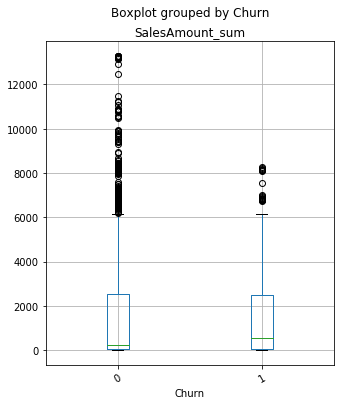

In [197]:
#https://www.datacamp.com/community/tutorials/categorical-data​​
final_data.boxplot('SalesAmount_sum','Churn',rot = 30,figsize=(5,6))

In [198]:
#reviewing the no of records in the target field - Churn
# total number of the customers= 18484
# 24% of the customer may likely churn
final_data['Churn'].value_counts()

0    14101
1     4383
Name: Churn, dtype: int64

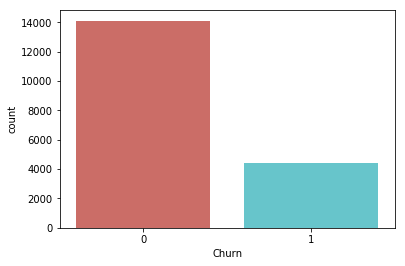

<Figure size 432x288 with 0 Axes>

In [199]:
#Display the distribution of the target variable - 0 = Non Churner - 1 = Churner
sns.countplot(x='Churn', data = final_data, palette = 'hls')
plt.show()
plt.savefig('count_plot')

In [200]:
final_data.groupby('Churn').mean()

,CustomerKey,SalesAmount_sum,SalesAmount_max,SalesAmount_min,SalesAmount_mean,SalesAmount_median,OrderQuantity_sum,OrderQuantity_max,OrderQuantity_min,OrderQuantity_mean,...,EnglishOccupation_Manual,EnglishOccupation_Professional,EnglishOccupation_Skilled Manual,HouseOwnerFlag_0,HouseOwnerFlag_1,CommuteDistance_0-1 Miles,CommuteDistance_1-2 Miles,CommuteDistance_10+ Miles,CommuteDistance_2-5 Miles,CommuteDistance_5-10 Miles
Churn,,,,,,,,,,,,,,,,,,,,,
0,19868.895043,1604.933745,997.414781,82.030004,445.127038,325.354758,3.472094,1.0,1.0,1.0,...,0.129069,0.304588,0.238139,0.320403,0.679597,0.341891,0.171619,0.138288,0.169137,0.179065
1,21440.245722,1534.909077,1179.822218,396.021776,706.472929,598.998523,2.609628,1.0,1.0,1.0,...,0.128679,0.279489,0.278120,0.334018,0.665982,0.339722,0.185261,0.124116,0.193703,0.157198


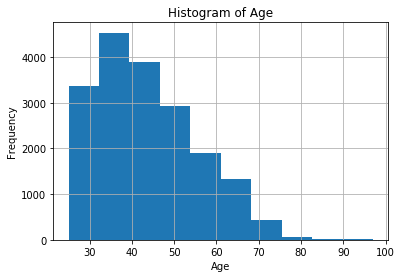

In [201]:
#Most of the customers in this dataset are in the age range of 40–50.
final_data.Age_years.hist()
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.savefig('hist_age')

In [202]:
plt.rcParams['figure.figsize'] = (17,8)

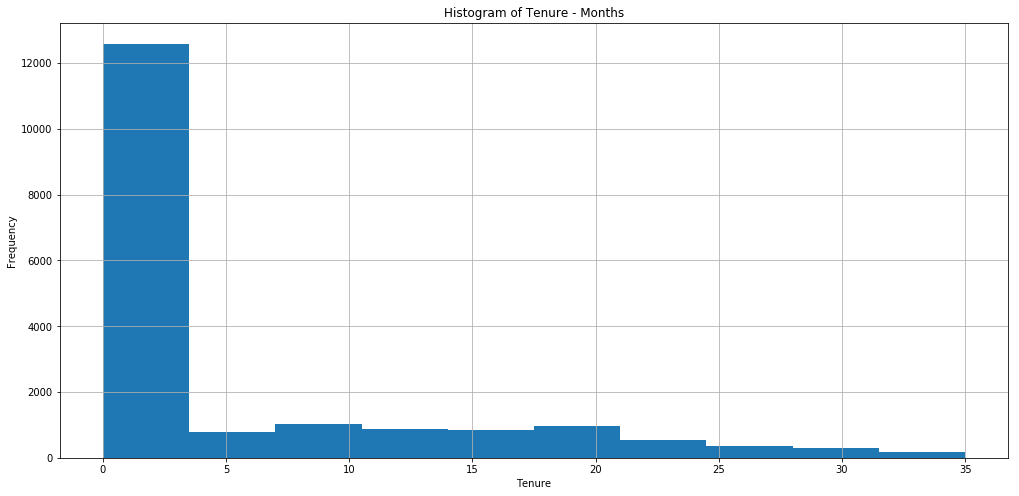

In [203]:
#Most of the customers in this dataset are quite new 0 - 4 months.
final_data.Tenure_Months.hist()
plt.title('Histogram of Tenure - Months')
plt.xlabel('Tenure')
plt.ylabel('Frequency')
plt.savefig('hist_age')

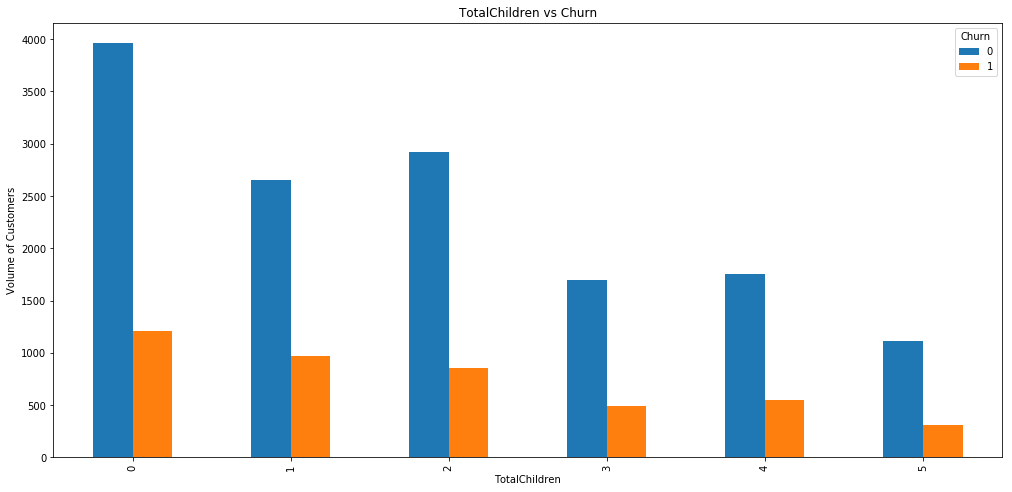

In [204]:
#No of children does not seem to be a good predictor of the outcome variable.
pd.crosstab(final_data.TotalChildren,final_data.Churn).plot(kind='bar')
plt.title('TotalChildren vs Churn')
plt.xlabel('TotalChildren')
plt.ylabel('Volume of Customers')
plt.savefig('pur_fre_pout_bar')

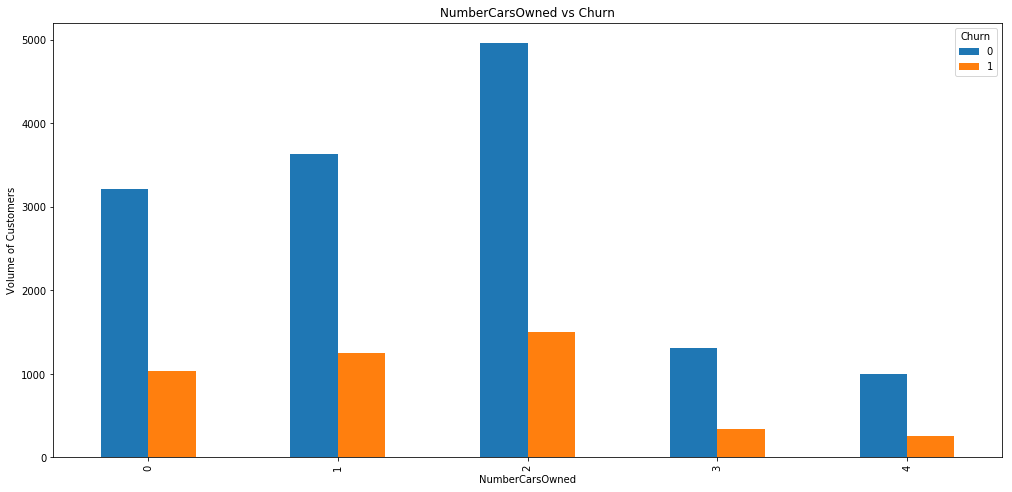

In [205]:
#those who have two cars are not likely to churn when comapred with other cars owners
pd.crosstab(final_data.NumberCarsOwned,final_data.Churn).plot(kind='bar')
plt.title('NumberCarsOwned vs Churn')
plt.xlabel('NumberCarsOwned')
plt.ylabel('Volume of Customers')
plt.savefig('pur_fre_pout_bar')

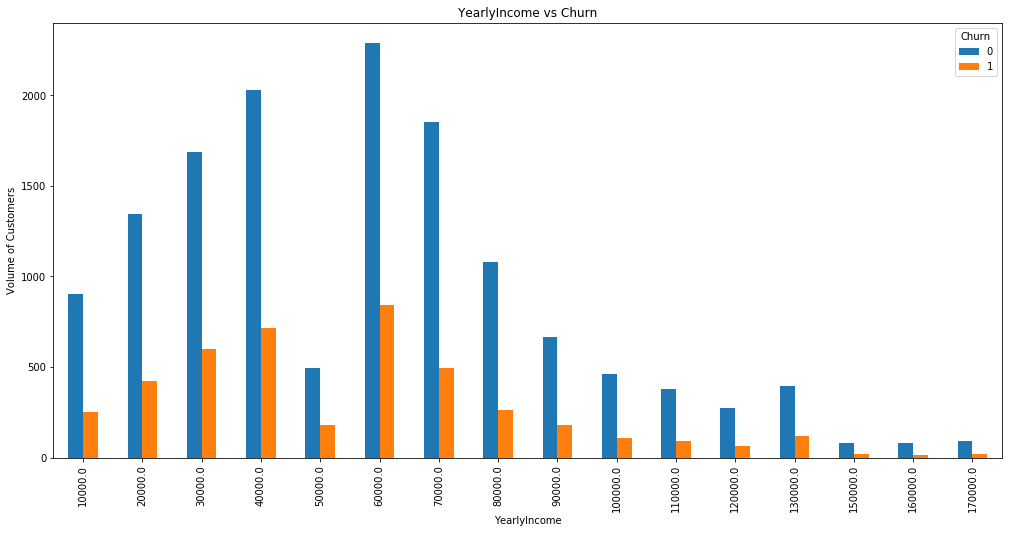

In [206]:
# Those who earn 60, 000 are less likely to churn
pd.crosstab(final_data.YearlyIncome,final_data.Churn).plot(kind='bar')
plt.title('YearlyIncome vs Churn')
plt.xlabel('YearlyIncome')
plt.ylabel('Volume of Customers')
plt.savefig('pur_fre_pout_bar')

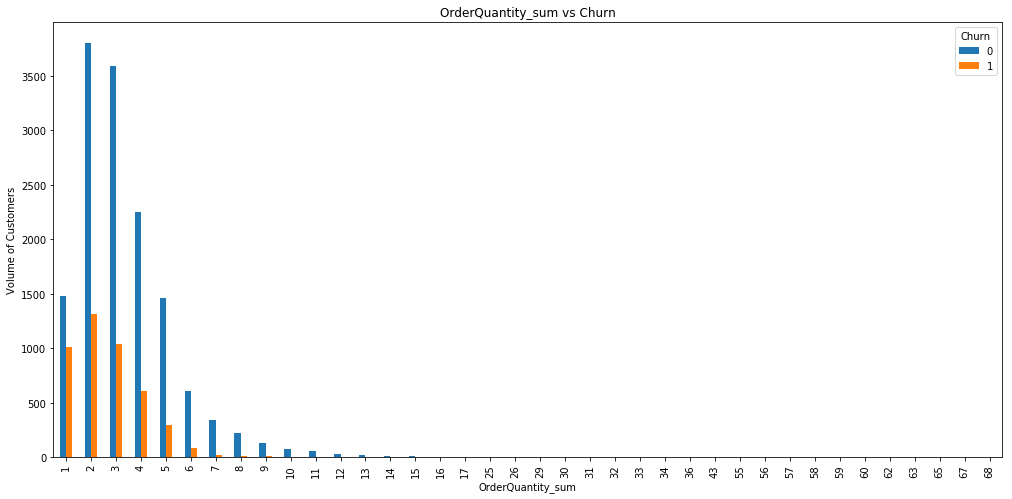

In [207]:
pd.crosstab(final_data.OrderQuantity_sum,final_data.Churn).plot(kind='bar')
plt.title('OrderQuantity_sum vs Churn')
plt.xlabel('OrderQuantity_sum')
plt.ylabel('Volume of Customers')
plt.savefig('pur_fre_pout_bar')

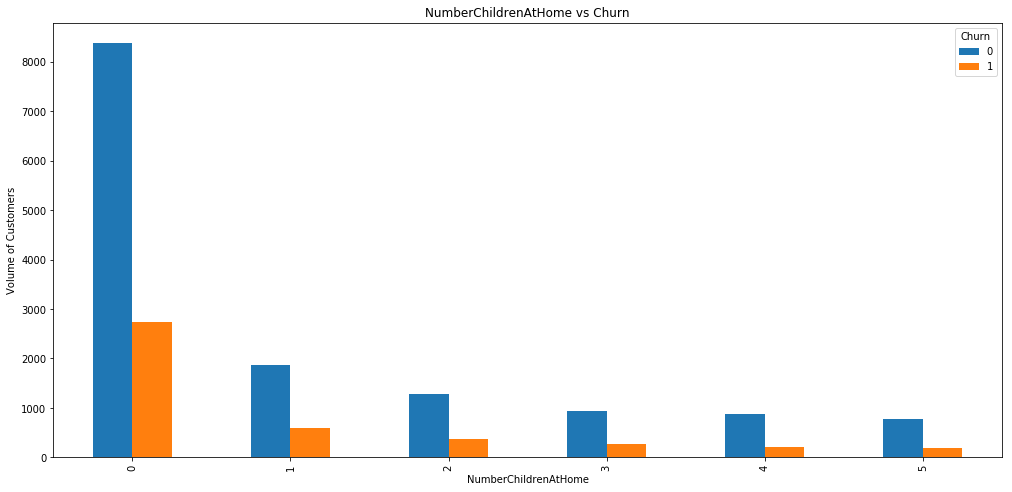

In [208]:
# Number of children at home appear not to have signifcant impact on churn and sales

pd.crosstab(final_data.NumberChildrenAtHome,final_data.Churn).plot(kind='bar')
plt.title('NumberChildrenAtHome vs Churn')
plt.xlabel('NumberChildrenAtHome')
plt.ylabel('Volume of Customers')
plt.savefig('pur_fre_pout_bar')

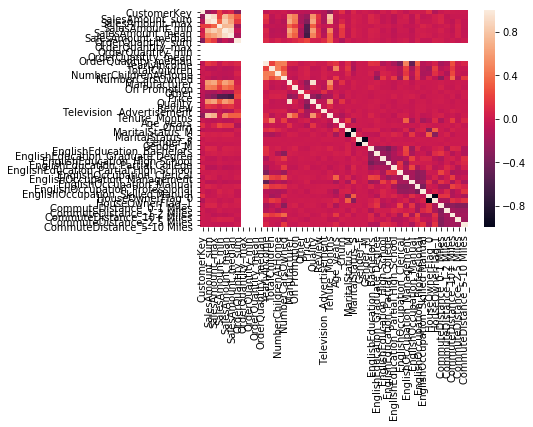

In [209]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
corr = final_data.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [210]:
# To visualise the data
final_data.corr()

,CustomerKey,SalesAmount_sum,SalesAmount_max,SalesAmount_min,SalesAmount_mean,SalesAmount_median,OrderQuantity_sum,OrderQuantity_max,OrderQuantity_min,OrderQuantity_mean,...,EnglishOccupation_Manual,EnglishOccupation_Professional,EnglishOccupation_Skilled Manual,HouseOwnerFlag_0,HouseOwnerFlag_1,CommuteDistance_0-1 Miles,CommuteDistance_1-2 Miles,CommuteDistance_10+ Miles,CommuteDistance_2-5 Miles,CommuteDistance_5-10 Miles
CustomerKey,1.000000,-0.247659,-0.120823,0.183688,0.014939,0.070632,-0.327076,NaN,NaN,NaN,...,0.008602,0.014098,0.009092,0.124755,-0.124755,-0.008040,0.015603,0.004891,-0.003196,-0.006783
SalesAmount_sum,-0.247659,1.000000,0.919380,0.197229,0.738868,0.531686,0.293653,NaN,NaN,NaN,...,-0.070563,0.063464,-0.048958,-0.028746,0.028746,0.063662,-0.039686,-0.015691,-0.011473,-0.014229
SalesAmount_max,-0.120823,0.919380,1.000000,0.339959,0.850260,0.625282,0.164984,NaN,NaN,NaN,...,-0.063798,0.036859,-0.019423,-0.015911,0.015911,0.075706,-0.023979,-0.062954,0.024905,-0.038901
SalesAmount_min,0.183688,0.197229,0.339959,1.000000,0.732989,0.746151,-0.195114,NaN,NaN,NaN,...,-0.034781,-0.007584,0.065572,0.031162,-0.031162,-0.005275,0.017480,-0.040052,0.058215,-0.033172
SalesAmount_mean,0.014939,0.738868,0.850260,0.732989,1.000000,0.915837,-0.037023,NaN,NaN,NaN,...,-0.064598,0.028380,0.020261,0.007667,-0.007667,0.043316,-0.009299,-0.056185,0.048870,-0.043217
SalesAmount_median,0.070632,0.531686,0.625282,0.746151,0.915837,1.000000,-0.155428,NaN,NaN,NaN,...,-0.051987,0.023296,0.031492,0.021556,-0.021556,0.015619,-0.001589,-0.038545,0.051622,-0.034951
OrderQuantity_sum,-0.327076,0.293653,0.164984,-0.195114,-0.037023,-0.155428,1.000000,NaN,NaN,NaN,...,-0.053329,0.043207,-0.033225,-0.037400,0.037400,0.029975,-0.021239,0.004389,-0.026262,0.006154
OrderQuantity_max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OrderQuantity_min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OrderQuantity_mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [211]:
#Identify missing values
final_data.isnull().mean().sort_values(ascending=False)*100

Review                                  7.909543
Quality                                 7.909543
Price                                   7.909543
Other                                   7.909543
On Promotion                            7.909543
Manufacturer                            7.909543
Television  Advertisement               7.909543
BirthDate                               0.000000
DateFirstPurchase                       0.000000
NumberCarsOwned                         0.000000
NumberChildrenAtHome                    0.000000
TotalChildren                           0.000000
YearlyIncome                            0.000000
CommuteDistance_5-10 Miles              0.000000
OrderQuantity_median                    0.000000
OrderQuantity_mean                      0.000000
OrderQuantity_min                       0.000000
OrderQuantity_max                       0.000000
OrderQuantity_sum                       0.000000
SalesAmount_median                      0.000000
SalesAmount_mean    

In [212]:
#replace missing values with most frequent values
final_data = final_data.fillna(final_data.mode().iloc[0])

# 5. Feature selection

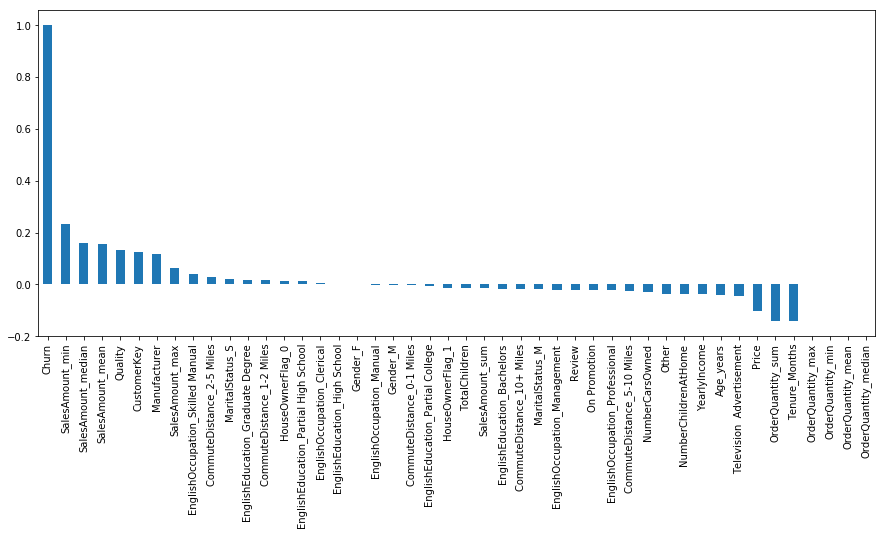

In [213]:

plt.figure(figsize=(15,6))
final_data.corr()['Churn'].sort_values(ascending=False).plot.bar()

In [ ]:
#We identify the following variables as an irrelvant variables becuase they all appear not to have signifcant impact on Churn.
# We include 'SalesAmount_median' and 'SalesAmount_mean' beacuse the two variables appear to be similar (Inclusion of the variables 
# may cause multicollinearity)
'MaritalStatus_S',
'CommuteDistance_2-5 Miles'
'EnglishEducation_Graduate Degree'
'EnglishEducation_Partial High School'
'EnglishOccupation_Clerical',
'EnglishEducation_High School',
'EnglishEducation_Bachelors'
'CommuteDistance_10+ Miles',
'TotalChildren'
'MaritalStatus_M',
'Gender_F', 
'HouseOwnerFlag_1',
'EnglishOccupation_Manual',
'Gender_M',
'CommuteDistance_0-1 Miles',
'EnglishEducation_Partial College',
'HouseOwnerFlag_1', 
'OrderQuantity_max', 
'OrderQuantity_min',
'OrderQuantity_mean',
'OrderQuantity_median',
'SalesAmount_mean',
'SalesAmount_median',
'SalesAmount_sum',
'EnglishOccupation_Skilled Manual', 





In [214]:

var_del = [ 'CommuteDistance_2-5 Miles','MaritalStatus_M','SalesAmount_sum','SalesAmount_median','EnglishEducation_Graduate Degree','CommuteDistance_10+ Miles','EnglishEducation_Bachelors','HouseOwnerFlag_1','EnglishOccupation_Clerical', 'EnglishEducation_High School', 'Gender_F', 'EnglishOccupation_Manual','Gender_M','CommuteDistance_0-1 Miles','EnglishEducation_Partial College',
'HouseOwnerFlag_1','OrderQuantity_max',  'MaritalStatus_M','OrderQuantity_min','TotalChildren','OrderQuantity_mean',
'OrderQuantity_median','SalesAmount_mean']

In [215]:
# we drop the variables
final_data.drop(var_del,axis = 1, inplace= True)

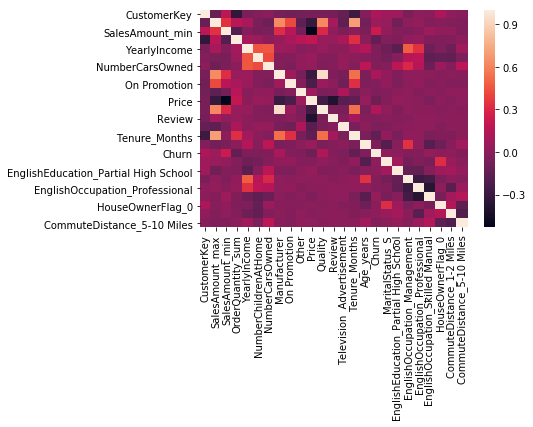

In [216]:
sns.heatmap(final_data.corr())

In [218]:
del_manufacturer = ['Manufacturer']
final_data.drop(del_manufacturer,axis = 1, inplace= True)

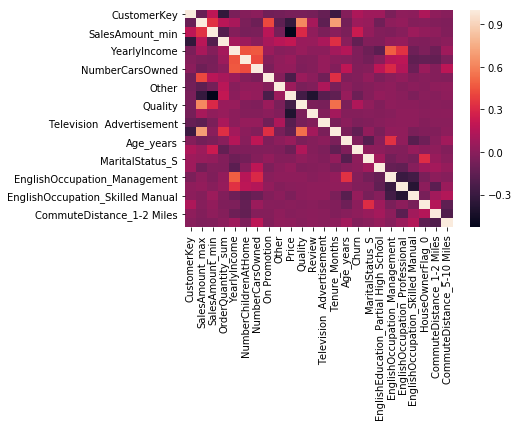

In [219]:
#To check for further multicollinearity
sns.heatmap(final_data.corr())

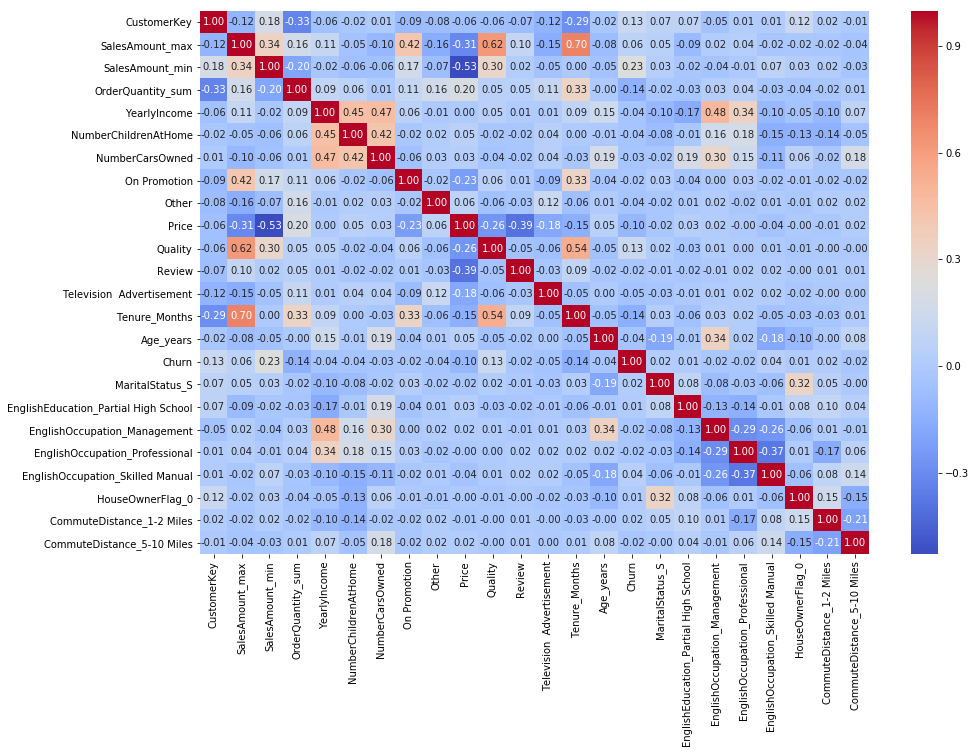

In [220]:

fig, ax = plt.subplots(figsize=(15,10))         
cm_df = sns.heatmap(final_data.corr(),annot=True, fmt = ".2f", cmap = "coolwarm", ax=ax)

In [221]:
# We also noticed that SalesAmount_max  has higher corrlation of 0.70 with Tenure_Months and Quality (0.62)

del_SalesAmount_max = ['SalesAmount_max']
final_data.drop(del_SalesAmount_max,axis = 1, inplace= True)

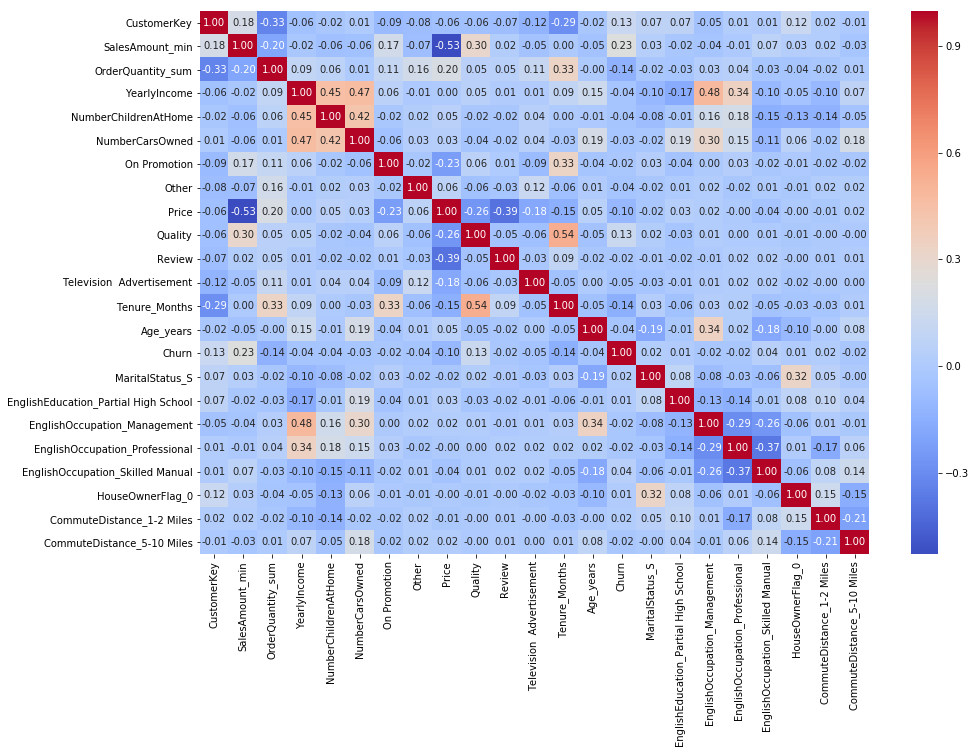

In [222]:
# We can see that all the variables have correlation that less than 0.70

fig, ax = plt.subplots(figsize=(15,10))         
cm_df = sns.heatmap(final_data.corr(),annot=True, fmt = ".2f", cmap = "coolwarm", ax=ax)

In [223]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18484 entries, 0 to 18483
Data columns (total 28 columns):
CustomerKey                             18484 non-null int64
SalesAmount_min                         18484 non-null float64
OrderQuantity_sum                       18484 non-null int64
OrderDate_max                           18484 non-null datetime64[ns]
BirthDate                               18484 non-null object
YearlyIncome                            18484 non-null float64
NumberChildrenAtHome                    18484 non-null int64
NumberCarsOwned                         18484 non-null int64
DateFirstPurchase                       18484 non-null object
On Promotion                            18484 non-null float64
Other                                   18484 non-null float64
Price                                   18484 non-null float64
Quality                                 18484 non-null float64
Review                                  18484 non-null float64
Television  

In [224]:
# we delect all dateimes and objects variables.  

date_del = ['Last_purchase_date','BirthDate','OrderDate_max','DateFirstPurchase','Cuttoff_date','DateFirstPurchase']
final_data.drop(date_del,axis = 1, inplace= True)



In [225]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18484 entries, 0 to 18483
Data columns (total 23 columns):
CustomerKey                             18484 non-null int64
SalesAmount_min                         18484 non-null float64
OrderQuantity_sum                       18484 non-null int64
YearlyIncome                            18484 non-null float64
NumberChildrenAtHome                    18484 non-null int64
NumberCarsOwned                         18484 non-null int64
On Promotion                            18484 non-null float64
Other                                   18484 non-null float64
Price                                   18484 non-null float64
Quality                                 18484 non-null float64
Review                                  18484 non-null float64
Television  Advertisement               18484 non-null float64
Tenure_Months                           18484 non-null int32
Age_years                               18484 non-null int32
Churn                

In [226]:
final_data.columns

Index(['CustomerKey', 'SalesAmount_min', 'OrderQuantity_sum', 'YearlyIncome',
       'NumberChildrenAtHome', 'NumberCarsOwned', 'On Promotion', 'Other',
       'Price', 'Quality', 'Review', 'Television  Advertisement',
       'Tenure_Months', 'Age_years', 'Churn', 'MaritalStatus_S',
       'EnglishEducation_Partial High School', 'EnglishOccupation_Management',
       'EnglishOccupation_Professional', 'EnglishOccupation_Skilled Manual',
       'HouseOwnerFlag_0', 'CommuteDistance_1-2 Miles',
       'CommuteDistance_5-10 Miles'],
      dtype='object')

# 6. Dataset validation


In [227]:

# We will use 80% of the dataset for modeling and hold back 20% for Test/Validation
x = final_data.drop('Churn',axis=1)
y = final_data['Churn']
validation_size = 0.20


seed = 7
num_folds = 10
scoring = 'accuracy'

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=validation_size, random_state=seed)


In [228]:

# Standardize the dataset
pipelines = []
pipelines.append(('LR', Pipeline([('Scaler', StandardScaler()), ('LR', LogisticRegression())])))
pipelines.append(('KNN', Pipeline([('Scaler', StandardScaler()), ('KNN', KNeighborsClassifier())])))
pipelines.append(('CART', Pipeline([('Scaler', StandardScaler()), ('CART', DecisionTreeClassifier())])))
pipelines.append(('NB', Pipeline([('Scaler', StandardScaler()), ('NB', GaussianNB())])))
pipelines.append(('RF', Pipeline([('Scaler', StandardScaler()), ('RF', RandomForestClassifier())])))

In [229]:

results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.789545 (0.007866)
KNN: 0.758165 (0.007685)
CART: 0.764862 (0.010697)
NB: 0.764185 (0.008128)
RF: 0.792791 (0.004600)


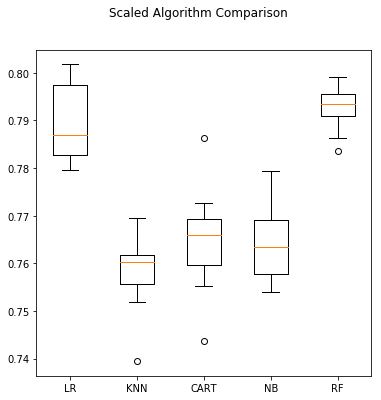

In [230]:

# Compare Algorithms
fig = plt.figure(figsize=(6,6))
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

From the above graph, LR model outperforms other selected models. However, this model can still be improved since our goal is to choose the best model with higher accuracy without overfitting. 

# 7. Improve performance of the selected models with the Boosting


In [ ]:
The application has ability to converts weak learners into better performing model. 

# Ada Boost with DecisionTreeClassifier

In [231]:
from sklearn.tree import DecisionTreeClassifier
addc = AdaBoostClassifier(DecisionTreeClassifier(), n_estimators = 10, learning_rate=1)
addc.fit(x_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1, n_estimators=10, random_state=None)

In [232]:
addc.score(x_test, y_test)

0.7746821747362727

In [233]:
cart_pred = addc.predict(x_test)
print (metrics.accuracy_score(y_test, cart_pred))

0.7746821747362727


# Ada Boosting with logisticRegression


In [234]:
addl = AdaBoostClassifier(LogisticRegression())
addl.fit(x_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          learning_rate=1.0, n_estimators=50, random_state=None)

In [235]:
addl.score(x_test, y_test)

0.7746821747362727

In [236]:
lr_pred = addl.predict(x_test)
print (metrics.accuracy_score(y_test, lr_pred))

0.7746821747362727


# Ada Boosting with Gaussian Bayesian naive


In [237]:
addn = AdaBoostClassifier(GaussianNB())
addn.fit(x_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=GaussianNB(priors=None), learning_rate=1.0,
          n_estimators=50, random_state=None)

In [238]:
addn.score(x_test, y_test)

0.4487422234243982

In [239]:
nby_pred = addn.predict(x_test)
print (metrics.accuracy_score(y_test, nby_pred))

0.4487422234243982


# Ada Boosting with RandomForestClassifier

In [240]:

addf = AdaBoostClassifier(RandomForestClassifier())
addf.fit(x_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          learning_rate=1.0, n_estimators=50, random_state=None)

In [241]:
addf.score(x_test, y_test)

0.781173924803895

# Viewing Booster accuracy 

In [242]:

with open('acuracy_score.csv', 'w', newline ='') as f:
    thewriter = csv.writer(f)
    
    thewriter.writerow(['Navie','Logist','DecsionTree','RandomForest'])
    thewriter.writerow([addn.score(x_train, y_train), addl.score(x_train, y_train),addc.score(x_train, y_train), addf.score(x_train, y_train)])

In [243]:
Acuracy = pd.read_csv('acuracy_score.csv')

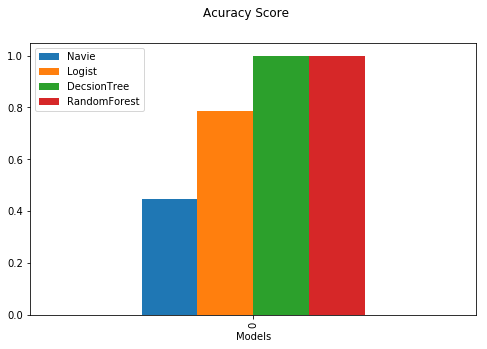

In [244]:
Acuracy.plot(kind = 'bar', figsize = (8, 5))
plt.suptitle('Acuracy Score')
plt.xlabel('Models')
plt.legend()
plt.show()

In [ ]:
We compare the accuracy score of the boosting with model withouth boosting

	Acuracy 	Acuracy +Boosting 
LR	0.789545	0.77468
CART 0.762359	0.77982
NB	0.764185	0.44874
RF	0.792994	0.78117
KNN	0.758165	

    
# I did not estimate 'KNN' with boosting. It appears that 
# AdaBoostClassifier does not support sample_weight for the two algorithims 

In general, the application of the Ada boosting with our selected models appear not to improve our prediction except for Decision tree classifier. To imporve further on this result, we applied XGBoost model

 # XGBoost


In [249]:
import xgboost as xgb
data_dmatrix = xgb.DMatrix(x_train, y_train)
xg_reg = xgb.XGBRegressor(objective ='reg:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [250]:
xg_reg.fit(x_train, y_train)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
       nthread=None, objective='reg:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [251]:
xg_best =  xg_reg.score(x_test, y_test)

In [252]:
print(xg_best)

0.04621941873787294


# Using  XGBoost to identify the important features


In [253]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

In [254]:
v_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

In [255]:
print((v_results["test-rmse-mean"]).tail(1))

49    0.391108
Name: test-rmse-mean, dtype: float64


In [256]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

In [257]:
plt.rcParams['figure.figsize'] = (17,8)

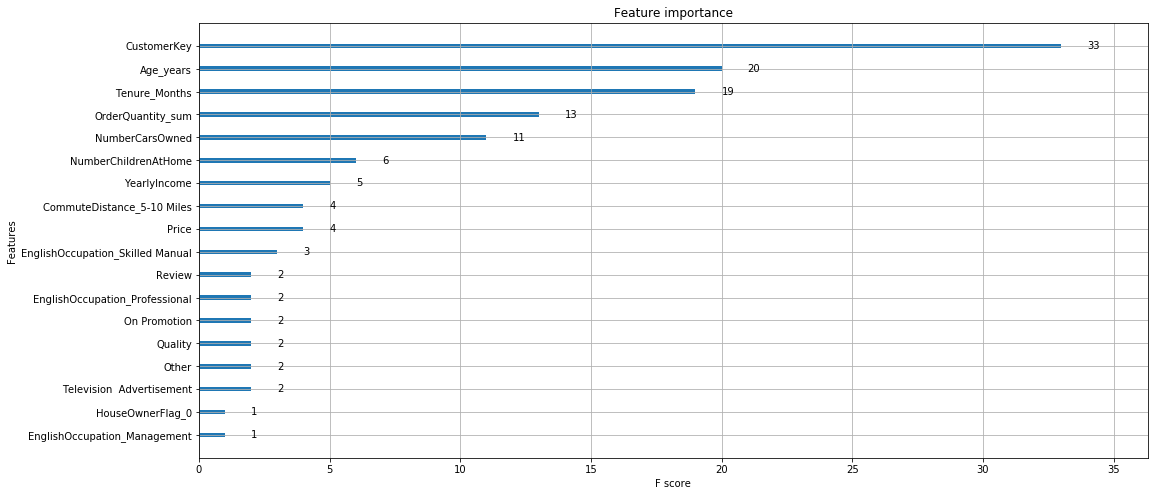

In [258]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

From the above graph, I displayed the scores of each variable for the prediction.  The chart counts the number of times each feature is split across all boosting rounds (trees) in the model, and then visualising the result as a bar graph, with the features ordered according to how many times they appear. In our case, CustomerKey, Age and Tenure_mothns have been given the highest importance score among all the features. 

For tenure months, this finding is reasonable because those who recently bought from the company may likely churn compared with old customers. Also, many companies tend to give their key customers special discounts like cash discount, trade discounts, quantity discounts and other privileges to encourage the customer to buy more products. The condition is that customer who tends to get more bonus may not churn.

# 8. Combined Voting Classifier using soft voting


In [259]:
# Voting Classifier on Multiple Models
from sklearn.ensemble import VotingClassifier
cart = DecisionTreeClassifier()
nb = GaussianNB()
lr = LogisticRegression()
knn =  KNeighborsClassifier(n_neighbors=5)
rf = RandomForestClassifier(random_state=1)


In [260]:

evc = VotingClassifier(estimators = [('cart', cart),('nb', nb), ('lr',lr),('rf', rf),('knn', knn)], voting = 'soft')

In [261]:
evc.fit(x_train, y_train)

VotingClassifier(estimators=[('cart', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_le...owski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [262]:
y_pred_voting = evc.predict(x_test)

In [263]:
sr_y_pred = evc.predict(x_test)
print (metrics.accuracy_score(y_test, sr_y_pred))

0.8011901541790641


In [264]:
 y_prob_voting = evc.predict_proba(x_test)[:,1]

In [265]:
com_rmse = np.sqrt(mean_squared_error(y_test, y_pred_voting))
print("RMSE: %f" % (com_rmse))

RMSE: 0.445881


In [266]:
# we check for overfitting
evc.score(x_train, y_train)

0.9319672685466964

Since combined voting classifier has higher accuracy over other selected models and the model does not overfit, we considered the voting classifier specification for customer churn prediction.

# 9. Model Evaluation 

# Calculate Confusion Matrix (Precision, Recall, Accuracy)


In [267]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score

In [268]:
def cal_evaluation(classifier, cm, auc):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    f1 = 2 * precision * recall / (precision + recall)
    print(classifier)
    print("Accuracy is " + str(accuracy))
    print("Precision is " + str(precision))
    print("Recall is " + str(recall))
    print("F1 score is " + str(f1))
    print("ROC AUC is " + str(auc))

def draw_confusion_matrices(confusion_matricies):
    class_names = ['Not','Churn']
    for x in confusion_matrices:
        classifier, cm, auc = x[0], x[1], x[2]
        cal_evaluation(classifier, cm, auc)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Reds'))
        plt.title('Confusion matrix for {}'.format(classifier))
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

Combined model
Accuracy is 0.8011901541790641
Precision is 0.7831715210355987
Recall is 0.26593406593406593
F1 score is 0.3970467596390484
ROC AUC is 0.7777668689401737


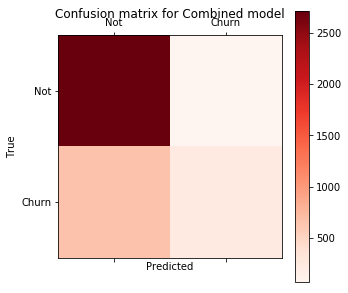

In [269]:

confusion_matrices = [
    ("Combined model", confusion_matrix(y_test, y_pred_voting), roc_auc_score(y_test, y_prob_voting))   
]
draw_confusion_matrices(confusion_matrices)

To maximise the chance of false positive prediction (predict an event when there was no event) and minimise the cost of false negative prediction (predict no event when in fact there was an event). I plot the graph of ROC with less than 0.5 threshold value. My expectation follows that a company will take precautionary measures to prevent likely churn customers.


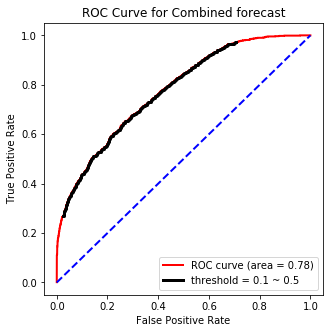

In [270]:

fpr, tpr, thresh = roc_curve(y_test, y_prob_voting, pos_label=1)
roc_auc = roc_auc_score(y_test, y_prob_voting)

# These are the points at threshold = 0.1~0.5
x1 = fpr[(thresh <= 0.5) & (thresh >= 0.1)] 
x2 = tpr[(thresh <= 0.5) & (thresh >= 0.1)]

fig = plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='b', lw=2, linestyle='--')
plt.plot(x1, x2, color='k', lw=3, label='threshold = 0.1 ~ 0.5')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Combined forecast')
plt.legend(loc="lower right")
plt.show()

From the above graph, the ROC curve moved toward the its otptimal level, this imply that the combined voting classifier is 76%
correctly predicts churn customers with less than 0.5 threshold value. 


# Examine relationship between Precision, Recall and  Accuracy

In [271]:

acc_grid = np.zeros(thresh.shape)
prec_grid = np.zeros(thresh.shape)
recall_grid = np.zeros(thresh.shape)
TP_grid = np.zeros(thresh.shape)
FP_grid = np.zeros(thresh.shape)
FN_grid = np.zeros(thresh.shape)

for i in range(thresh.shape[0]):
    cm = confusion_matrix(y_test, y_prob_voting >= thresh[i])
    acc_grid[i] = accuracy_score(y_test, y_prob_voting >= thresh[i])
    prec_grid[i] = precision_score(y_test, y_prob_voting>= thresh[i])
    recall_grid[i] = recall_score(y_test, y_prob_voting >= thresh[i])
    TP_grid[i] = cm[1][1]
    FP_grid[i] = cm[0][1]
    FN_grid[i] = cm[1][0]

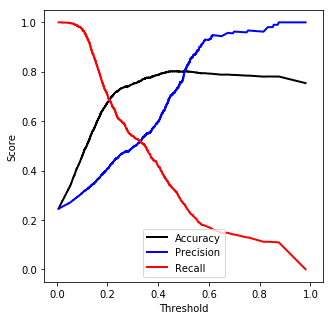

In [272]:
fig = plt.figure()
plt.plot(thresh, acc_grid, color='k', lw=2, label='Accuracy')
plt.plot(thresh, prec_grid, color='b', lw=2, label='Precision')
plt.plot(thresh, recall_grid, color='r', lw=2, label='Recall')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend(loc="lower center")
plt.show()

From the graph, this study indicates that there is an inverse relationship between the accuracy, precision and recall, this result imply that an increase in accuracy and precision of the voting classifier model come at the cost of decreasing the recall value.